# Introduction
The primary question we're investigating is: Which team metrics exhibit the highest correlation with regular season wins in the NBA?

We're analyzing a comprehensive set of data from previous NBA season that show team metrics per season (outlined in Glossary within the Data Cleaning section).

By examining this vast dataset, we hope to uncover key performance indicators that teams should prioritize for success. While there are factors beyond statistical analysis that influence a team's performance, we believe that analyzing will provide valuable insights.

# Scope Revision (Changes)

Initially, we aimed to explore how individual player metrics impact overall team performance in the NBA. However, we refined our focus to investigate the team metric that most significantly influences a team's ability to win.

Reasoning: Analyzing individual metrics and correlating that with team metrics is very complex and general. There are numerous factors that can change a team’s ability to win that are not affected by an individual. 

Looking at team metrics gives more nuanced insights into what team statistics correlate with a better team performance.


# Data Cleaning
Cleaning methods on csv files:
- Manually added the W/L% from other tables
- removed "*" from respective team names manually 
- removed the last column (as league averages were insignificant to analysis)

The CSV files had no null values and were relatively clean in respect to the analysis.

Creating a dataframe with all data from the cleaned csv files and differentiating them by ending year:


In [17]:
# Adding proper imports for data processing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import myFunctions
from scipy.stats import pearsonr

# Data Cleaning
df_season1 = myFunctions.clean_data('2022-23.csv')
df_season2 = myFunctions.clean_data('2021-22.csv')
df_season3 = myFunctions.clean_data('2020-21.csv')
df_season1['YR'] = 2021  
df_season2['YR'] = 2022  
df_season3['YR'] = 2023  

merged_df = pd.concat([df_season1, df_season2, df_season3], ignore_index=True)

## Glossary for DataFrames
| Abbreviation | Definition                       | Abbreviation | Definition               | Abbreviation | Definition               | Abbreviation | Definition               |
|--------------|----------------------------------|--------------|--------------------------|--------------|--------------------------|--------------|--------------------------|
| Rk           | Rank                             | G            | Games                    | MP           | Minutes Played           | FG           | Field Goals              |
| FGA          | Field Goal Attempts              | FG%          | Field Goal Percentage    | 3P           | 3-Point Field Goals      | 3PA          | 3-Point FG Attempts      |
| 3P%          | 3-Point FG Percentage            | 2P           | 2-Point FG               | 2PA          | 2-Point FG Attempts      | 2P%          | 2-Point FG Percentage    |
| FT           | Free Throws                      | FTA          | Free Throw Attempts      | FT%          | Free Throw Percentage    | ORB          | Offensive Rebounds       |
| DRB          | Defensive Rebounds               | TRB          | Total Rebounds           | AST          | Assists                  | STL          | Steals                   |
| BLK          | Blocks                           | TOV          | Turnovers                | PF           | Personal Fouls           | PTS          | Points                   |
| W/L%         | Win to Loss Percentage           | YR           | Year                     |              |                          |              |                          |


# EDA
The code below performs exploratory data analysis (EDA) on team metrics across seasons ending in 2021-2023, while utilizing **find_most_important_metric** to calculate the average correlation of team metrics with win/loss percentage (W/L%). 

Positive correlations are observed for metrics associated with scoring points, while turnovers (TOV) show a moderate negative correlation with win/loss percentage (W/L%).

Team Metric Averages for Seasons 2021-2023
3P%    0.789905
FG%    0.691194
PTS    0.621528
2P%    0.560542
FG     0.487685
Name: W/L%, dtype: float64
The most important metric for W/L% is: 3P%


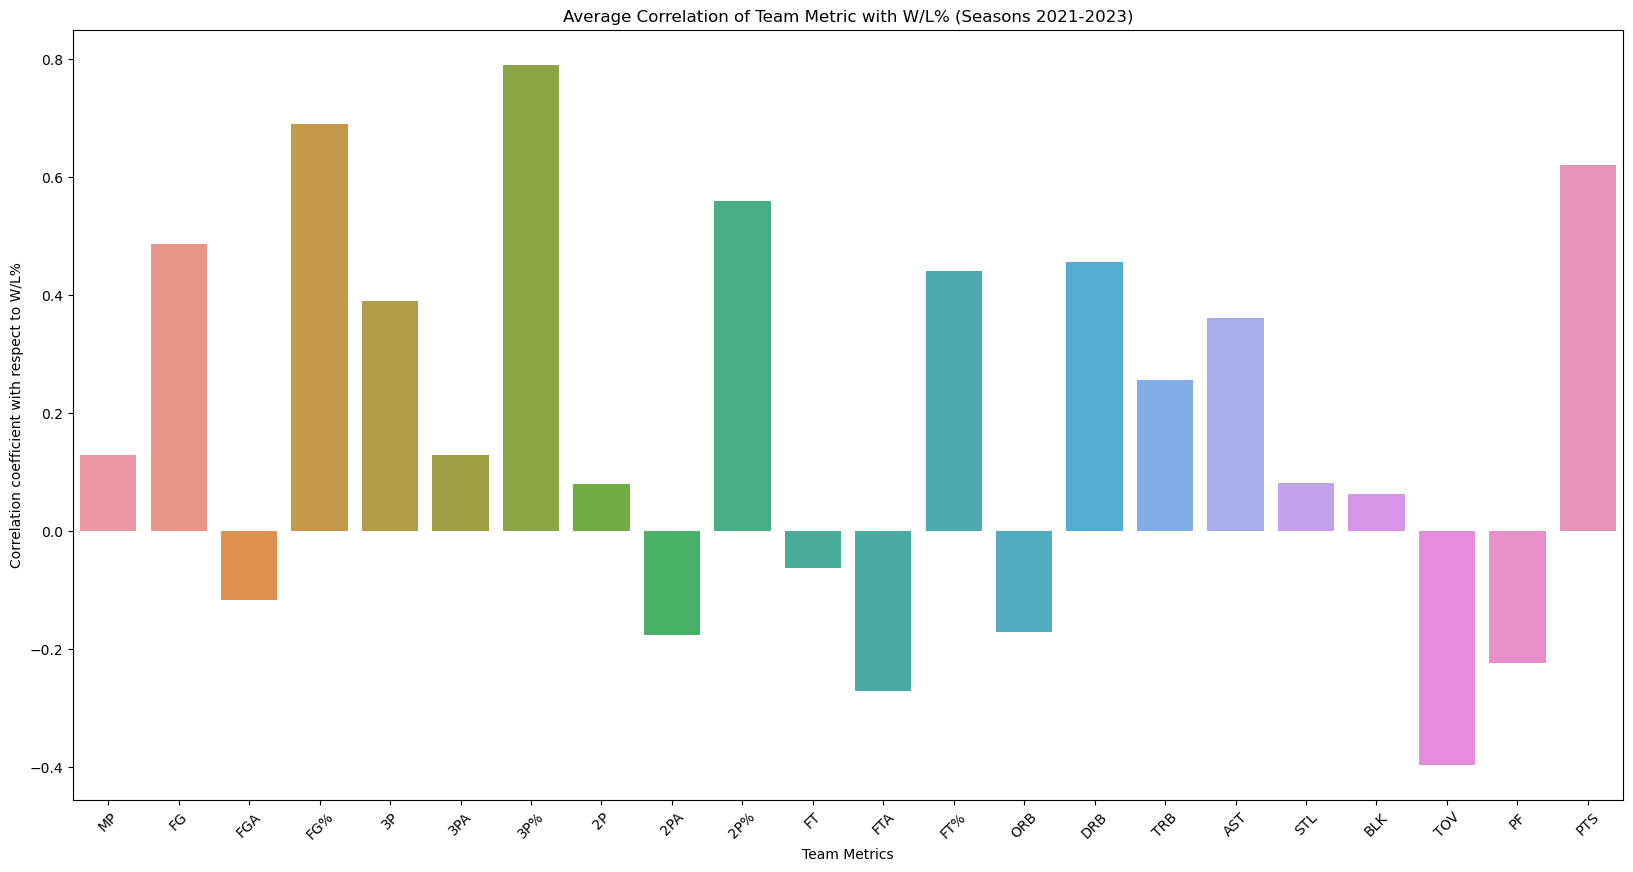

In [18]:
EDA_data = merged_df.copy()
EDA_data = EDA_data.groupby('Team').mean().reset_index()
EDA_data.drop('YR', axis=1, inplace=True)

print("Team Metric Averages for Seasons 2021-2023")
avg_correlation_with_WL = myFunctions.find_most_important_metric(EDA_data)

myFunctions.bar_plot_correlation(avg_correlation_with_WL, 'Average Correlation of Team Metric with W/L% (Seasons 2021-2023)')

# Visualizations
#### **Hypothesis 1:** Teams with higher shooting percentages (FG%) tend to have a higher win percentage.

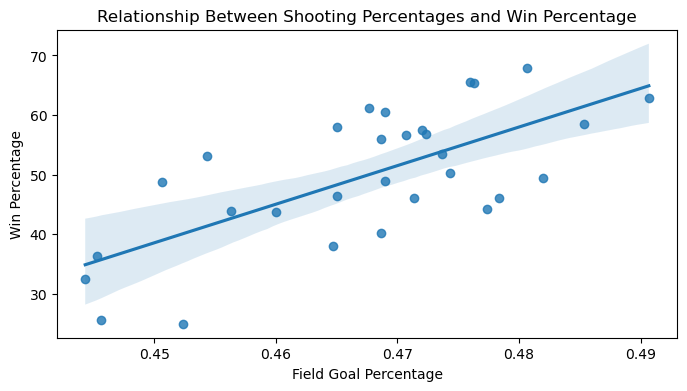

In [19]:
selected_data = merged_df.groupby('Team')[['FG%', 'W/L%']].mean().reset_index()
plt.figure(figsize=(8, 4))
sns.regplot(data=selected_data, x='FG%', y='W/L%')
plt.title('Relationship Between Shooting Percentages and Win Percentage')
plt.xlabel('Field Goal Percentage')
plt.ylabel('Win Percentage')
plt.show()

This plot visualizes the relationship between shooting efficiency, represented by Field Goal Percentage (FG%), and win percentage (W/L%) for each team. Each point on the scatter plot represents a team, where the x-coordinate represents the average FG% and the y-coordinate represents the average win percentage. Additionally, a regression line is included to show the overall trend between FG% and W/L%. The regression line is linear and increasing, which indicates a positive correlation between the field goal percentage and the win percentage. 

# ML Analysis

We utilized a *Logistic Regression model* to categorize win/loss percentages into binary outcomes ('Winning' or 'Losing') using a threshold (51%).

Additionally, we conducted feature selection to identify pertinent features ('3P%', '2P%', 'FG%', 'PTS', 'TOV') and the target variable *('W/L%')* for training the LR model.

The dataset was split into training and testing sets using train_test_split, features were standardized with StandardScaler, and trained the logistic regression model on the training data using LogisticRegression() from scikit-learn. 

After training the model, we made predictions on the testing set using model.predict(X_test) and calculated the accuracy of the model. Then, The trained model was applied to predict win/loss outcomes for the unseen season (2022-23) based on selected features.

In [23]:
accuracy, correct_predictions, total_predictions = myFunctions.train_and_predict(df_season1, df_season2, df_season3)
# Print accuracy and number of correct predictions for the unseen season
print(f"\nAccuracy of unseen season: {accuracy:.2f}% ({correct_predictions} out of {total_predictions} correct predictions)")

3P%    0.628592
FG%    0.533804
PTS    0.477897
2P%    0.439179
TOV    0.416737
Name: W/L%, dtype: float64
The most important metric for W/L% is: 3P%
Accuracy: 0.8333333333333334

Accuracy of unseen season: 73.33% (22 out of 30 correct predictions)


# Hypothesis Testing
**Hypothesis 1:**
Teams with higher shooting percentages (FG%) tend to have a higher win percentage.

Null Hypothesis (H0): There is no significant correlation between field goal percentage (FG%) and win percentage (W/L%).

Alternative Hypothesis (H1): There is a significant positive correlation between field goal percentage (FG%) and win percentage (W/L%).

To test this hypothesis, we'll perform Pearson correlation coefficient analysis and conduct a significance test with a significance level (α) of 0.05.

In [24]:
# Extract relevant data
shooting_percentage = merged_df['FG%']
win_percentage = merged_df['W/L%']

# Calculate Pearson correlation coefficient and p-value
corr, p_value = pearsonr(shooting_percentage, win_percentage)

# Output results
print("Pearson Correlation Coefficient:", corr)
print("P-value:", p_value)

# Interpret results
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant positive correlation between FG% and W/L%.")
else:
    print("Fail to reject the null hypothesis. There is no significant correlation between FG% and W/L%.")


Pearson Correlation Coefficient: 0.6072987985155591
P-value: 2.2087444436113241e-10
Reject the null hypothesis. There is a significant positive correlation between FG% and W/L%.


**Results and Interpretation:** The Pearson correlation coefficient between field goal percentage (FG%) and win percentage (W/L%) is calculated, along with the p-value. Based on the significance level of 0.05, we can determine that we should reject the null hypothesis. The Pearson correlation coefficient of 0.607 indicates a strong positive linear relationship between FG% and W/L% meaning teams with higher field goal percentages tend to have higher win percentages, suggesting that shooting efficiency plays a crucial role in determining team success in the NBA regular season. 


**Hypothesis 2:** Teams with higher three-point shooting percentages (3PT%) tend to have a higher win percentage.

Null Hypothesis (H0): There is no significant correlation between three-point shooting percentage (3PT%) and win percentage (W/L%).

Alternative Hypothesis (H1): There is a significant positive correlation between three-point shooting percentage (3PT%) and win percentage (W/L%).

We'll again use the Pearson correlation coefficient analysis and conduct a significance test with a significance level (α) of 0.05.

In [25]:
# Extract relevant data
three_point_percentage = merged_df['3P%']

# Calculate Pearson correlation coefficient and p-value
corr_3pt, p_value_3pt = pearsonr(three_point_percentage, win_percentage)

# Output results
print("Pearson Correlation Coefficient (3PT% vs. W/L%):", corr_3pt)
print("P-value (3PT% vs. W/L%):", p_value_3pt)

# Interpret results
if p_value_3pt < 0.05:
    print("Reject the null hypothesis. There is a significant positive correlation between 3PT% and W/L%.")
else:
    print("Fail to reject the null hypothesis. There is no significant correlation between 3PT% and W/L%.")


Pearson Correlation Coefficient (3PT% vs. W/L%): 0.666358360391921
P-value (3PT% vs. W/L%): 7.604107459562444e-13
Reject the null hypothesis. There is a significant positive correlation between 3PT% and W/L%.


**Results and Interpretation:** Based on the Pearson correlation coefficient of approximately 0.666 and the very low p-value (7.604e-13), we reject the null hypothesis. This indicates a significant positive correlation between three-point shooting percentage (3PT%) and win percentage (W/L%). The strong positive correlation between three-point shooting percentage and win percentage suggests that teams with higher three-point shooting efficiency tend to have higher win percentages in NBA regular season games. This finding has important implications for team strategies, player development, and recruitment, highlighting the importance of three-point shooting in achieving success in basketball.

# Reflection
**Challenges:** Implementing the ML models was also challenging due to the ambiguity surrounding their purpose within the project's scope. We faced difficulty in interpreting the results of the models and integrating them effectively into our analysis.

**Insights:** Despite challenges, our initial insights are promising. We've laid a strong foundation, ready to integrate future data, such as previous season statistics. EDA provided valuable insights into team metrics' relationships and win percentage, while ML models offer predictive capabilities for team success.

**Concrete Results:** We've achieved tangible results at every stage: data cleaning/standardization, comprehensive EDA, and ML model construction to predict team performance based on various metrics.

**Current Biggest Problems:** Further increasing model accuracy and finding effective ML models that meet our standards are our main concerns. Balancing accuracy, avoiding overfitting, and ensuring model generalizability remain top priorities.

**Project Tracking:** Despite challenges, we're on track with the project, building upon a solid foundation with an iterative approach for continuous improvement. Our focus remains on refining models for effective result interpretation.

**Worth Proceeding:**  The insights obtained and the potential for further analysis/model refinement justify proceeding with the project.

# Next Steps

In the upcoming month, our primary goal is to enhance the interpretability of our machine learning models. We'll achieve this by refining hyperparameters, exploring new feature engineering techniques, and improving model interpretability with effective visualization methods. Clear milestones and deadlines will be set to ensure collaboration among team members, fostering steady progress and accountability.

###### LINK TO NOTEBOOK IN REPO: https://github.com/uic-cs418/group-project-big-b/blob/main/Progress%20Report%20Notebook.ipynb